## PACS Domain Generalization with Vision Transformer (ViT)

### Setup & Imports

In [12]:

import os
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset
from sklearn.model_selection import train_test_split
from transformers import ViTForImageClassification, ViTFeatureExtractor
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import random


### Configuration & Seeds

In [3]:

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")
SEED = 42
BATCH_SIZE = 24
NUM_EPOCHS = 5
NUM_CLASSES = 7
DATA_ROOT = "pacs_data/pacs_data"
DOMAINS = ["art_painting", "cartoon", "photo", "sketch"]

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


Device: cuda


### Dataset Wrapper Class

In [4]:

class PACSDataset:
    def __init__(self, data_root, domains, transform):
        self.data_root = data_root
        self.domains = domains
        self.transform = transform

    def get_dataloader(self, domain, train=True):
        dataset = datasets.ImageFolder(os.path.join(self.data_root, domain), transform=self.transform)
        
        indices = list(range(len(dataset)))
        train_idx, val_idx = train_test_split(indices, test_size=0.2, stratify=[dataset.targets[i] for i in indices], random_state=SEED)
        selected_idx = train_idx if train else val_idx
        
        subset = Subset(dataset, selected_idx)
        loader = DataLoader(subset, batch_size=BATCH_SIZE, shuffle=train)
        return loader


### Vision Transformer Wrapper Class

In [5]:

class ViTModel(nn.Module):
    def __init__(self, num_classes):
        super(ViTModel, self).__init__()
        self.model = ViTForImageClassification.from_pretrained(
            'google/vit-base-patch16-224-in21k',
            num_labels=num_classes,
            ignore_mismatched_sizes=True
        )

    def forward(self, x):
        return self.model(x).logits


### Trainer Class

In [6]:

class Trainer:
    def __init__(self, model, optimizer, criterion):
        self.model = model.to(DEVICE)
        self.optimizer = optimizer
        self.criterion = criterion

    def train(self, dataloader):
        self.model.train()
        total_loss = 0
        for inputs, labels in tqdm(dataloader):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
        return total_loss / len(dataloader)

    def evaluate(self, dataloader):
        self.model.eval()
        total_correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = self.model(inputs)
                preds = torch.argmax(outputs, dim=1)
                total_correct += (preds == labels).sum().item()
                total += labels.size(0)
        return total_correct / total


### Leave-One-Domain-Out (LODO) Training

In [ ]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

results = {}

for test_domain in DOMAINS:
    print(f"\Testing on domain: {test_domain}")
    train_domains = [d for d in DOMAINS if d != test_domain]

    # Load datasets
    dataset = PACSDataset(DATA_ROOT, DOMAINS, transform)
    train_loaders = [dataset.get_dataloader(d, train=True) for d in train_domains]
    val_loaders = [dataset.get_dataloader(d, train=False) for d in train_domains]
    test_loader = dataset.get_dataloader(test_domain, train=False)

    # Concatenate datasets
    train_ds = ConcatDataset([dl.dataset for dl in train_loaders])
    val_ds = ConcatDataset([dl.dataset for dl in val_loaders])

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

    # Initialize model, optimizer, and criterion
    model = ViTModel(NUM_CLASSES)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()
    trainer = Trainer(model, optimizer, criterion)

    # Train
    for epoch in range(NUM_EPOCHS):
        print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")
        train_loss = trainer.train(train_loader)
        val_acc = trainer.evaluate(val_loader)
        print(f"Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Test
    test_acc = trainer.evaluate(test_loader)
    results[test_domain] = test_acc
    print(f"✅ Test Accuracy on {test_domain}: {test_acc:.4f}")


🧪 Testing on domain: art_painting


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


100%|██████████| 265/265 [01:23<00:00,  3.19it/s]


Train Loss: 0.4924 | Val Acc: 0.9490
Epoch 2/5


100%|██████████| 265/265 [00:30<00:00,  8.73it/s]


Train Loss: 0.1082 | Val Acc: 0.9610
Epoch 3/5


100%|██████████| 265/265 [00:30<00:00,  8.65it/s]


Train Loss: 0.0609 | Val Acc: 0.9578
Epoch 4/5


100%|██████████| 265/265 [00:30<00:00,  8.72it/s]


Train Loss: 0.0612 | Val Acc: 0.9509
Epoch 5/5


100%|██████████| 265/265 [00:30<00:00,  8.75it/s]


Train Loss: 0.0305 | Val Acc: 0.9585
✅ Test Accuracy on art_painting: 0.9220

🧪 Testing on domain: cartoon


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


100%|██████████| 255/255 [00:37<00:00,  6.89it/s]


Train Loss: 0.4805 | Val Acc: 0.9562
Epoch 2/5


100%|██████████| 255/255 [00:29<00:00,  8.77it/s]


Train Loss: 0.1158 | Val Acc: 0.9536
Epoch 3/5


100%|██████████| 255/255 [00:29<00:00,  8.79it/s]


Train Loss: 0.0660 | Val Acc: 0.9582
Epoch 4/5


100%|██████████| 255/255 [00:29<00:00,  8.75it/s]


Train Loss: 0.0498 | Val Acc: 0.9503
Epoch 5/5


100%|██████████| 255/255 [00:29<00:00,  8.77it/s]


Train Loss: 0.0362 | Val Acc: 0.9484
✅ Test Accuracy on cartoon: 0.7974

🧪 Testing on domain: photo


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


100%|██████████| 278/278 [00:32<00:00,  8.68it/s]


Train Loss: 0.5252 | Val Acc: 0.9405
Epoch 2/5


100%|██████████| 278/278 [00:31<00:00,  8.71it/s]


Train Loss: 0.1266 | Val Acc: 0.9369
Epoch 3/5


100%|██████████| 278/278 [00:31<00:00,  8.69it/s]


Train Loss: 0.0734 | Val Acc: 0.9532
Epoch 4/5


100%|██████████| 278/278 [00:31<00:00,  8.71it/s]


Train Loss: 0.0429 | Val Acc: 0.9477
Epoch 5/5


100%|██████████| 278/278 [00:32<00:00,  8.67it/s]


Train Loss: 0.0378 | Val Acc: 0.9628
✅ Test Accuracy on photo: 0.9940

🧪 Testing on domain: sketch


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


100%|██████████| 203/203 [00:23<00:00,  8.60it/s]


Train Loss: 0.4620 | Val Acc: 0.9365
Epoch 2/5


100%|██████████| 203/203 [00:23<00:00,  8.65it/s]


Train Loss: 0.0768 | Val Acc: 0.9678
Epoch 3/5


100%|██████████| 203/203 [00:23<00:00,  8.66it/s]


Train Loss: 0.0584 | Val Acc: 0.9687
Epoch 4/5


100%|██████████| 203/203 [00:23<00:00,  8.69it/s]


Train Loss: 0.0335 | Val Acc: 0.9580
Epoch 5/5


100%|██████████| 203/203 [00:23<00:00,  8.67it/s]


Train Loss: 0.0337 | Val Acc: 0.9646
✅ Test Accuracy on sketch: 0.4949


### Baseline

In [ ]:
print("\Baseline: training on all domains and testing on mixed domains")
# Load full train and test sets via leave-all-in loaders
dataset_all = PACSDataset(DATA_ROOT, DOMAINS, transform)
all_train_loaders = [dataset_all.get_dataloader(d, train=True) for d in DOMAINS]
all_test_loaders = [dataset_all.get_dataloader(d, train=False) for d in DOMAINS]

# Concatenate
full_train_ds = ConcatDataset([dl.dataset for dl in all_train_loaders])
full_test_ds = ConcatDataset([dl.dataset for dl in all_test_loaders])
full_train_loader = DataLoader(full_train_ds, batch_size=BATCH_SIZE, shuffle=True)
full_test_loader = DataLoader(full_test_ds, batch_size=BATCH_SIZE, shuffle=False)

# Initialize baseline model
baseline_model = ViTModel(NUM_CLASSES)
baseline_optimizer = optim.Adam(baseline_model.parameters(), lr=1e-4)
baseline_criterion = nn.CrossEntropyLoss()
baseline_trainer = Trainer(baseline_model, baseline_optimizer, baseline_criterion)

# Train baseline
for epoch in range(NUM_EPOCHS):
    print(f"Baseline Epoch {epoch + 1}/{NUM_EPOCHS}")
    baseline_loss = baseline_trainer.train(full_train_loader)
    baseline_val_acc = baseline_trainer.evaluate(full_test_loader)
    print(f"Baseline Loss: {baseline_loss:.4f} | Baseline Acc: {baseline_val_acc:.4f}")

# Test baseline
baseline_test_acc = baseline_trainer.evaluate(full_test_loader)
results['baseline_all_domains'] = baseline_test_acc
print(f"Baseline Test Accuracy: {baseline_test_acc:.4f}")



🏁 Baseline: training on all domains and testing on mixed domains


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Baseline Epoch 1/5


100%|██████████| 333/333 [00:38<00:00,  8.75it/s]


Baseline Loss: 0.4889 | Baseline Acc: 0.9525
Baseline Epoch 2/5


100%|██████████| 333/333 [00:38<00:00,  8.76it/s]


Baseline Loss: 0.1086 | Baseline Acc: 0.9335
Baseline Epoch 3/5


100%|██████████| 333/333 [00:38<00:00,  8.76it/s]


Baseline Loss: 0.0611 | Baseline Acc: 0.9525
Baseline Epoch 4/5


100%|██████████| 333/333 [00:43<00:00,  7.74it/s]


Baseline Loss: 0.0412 | Baseline Acc: 0.9490
Baseline Epoch 5/5


100%|██████████| 333/333 [00:38<00:00,  8.74it/s]


Baseline Loss: 0.0400 | Baseline Acc: 0.9550
✅ Baseline Test Accuracy: 0.9550


### Visual Comparison

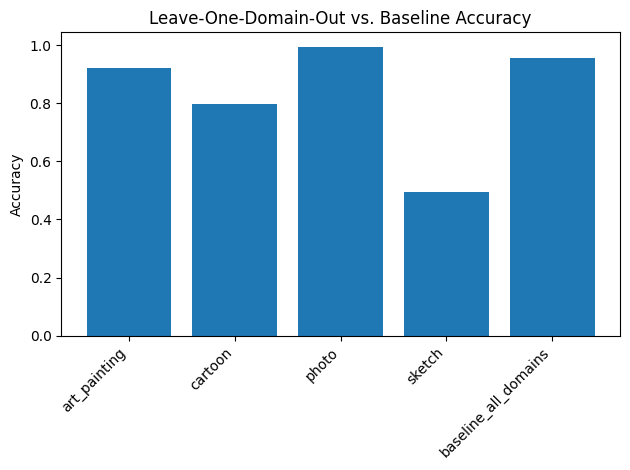

In [13]:
domains = list(results.keys())
accuracies = [results[d] for d in domains]

plt.figure()
plt.bar(domains, accuracies)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.title('Leave-One-Domain-Out vs. Baseline Accuracy')
plt.tight_layout()
plt.show()

### 7. Final Results

In [ ]:

print("\Final Results (LODO Accuracy):")
for domain, acc in results.items():
    print(f"{domain}: {acc:.4f}")

avg_acc = sum(results.values()) / len(results)
print(f"\nAverage Accuracy: {avg_acc:.4f}")



📊 Final Results (LODO Accuracy):
art_painting: 0.9220
cartoon: 0.7974
photo: 0.9940
sketch: 0.4949
baseline_all_domains: 0.9550

Average Accuracy: 0.8327
